## 1. Loading the data

In [1]:
from dataset import SubjectTrialDataset_SingleElectrode
from subject_braintreebank import BrainTreebankSubject
from subject_ajile12 import AjileSubject
import torch
from model_model import BFModule
from model_transformers import Transformer
import torch.nn as nn
from train_utils import log
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log(f'Using device: {device}')
dtype = torch.bfloat16

subject_id, trial_id = 3, 4
window_size = 512
subject = AjileSubject(subject_id, cache=True)
electrode_subset = ["10GRID"]
subject.set_electrode_subset(electrode_subset)
dataset = SubjectTrialDataset_SingleElectrode(subject, trial_id, window_size=window_size, dtype=dtype, unsqueeze_electrode_dimension=False, electrodes_subset=electrode_subset)
log("Data shape: " + str(dataset[0]['data'].shape))

[20:28:48 gpu 0.0G ram 0.5G] (0) Using device: cuda
[20:28:53 gpu 0.0G ram 0.7G] (0) Data shape: torch.Size([512])


## 2. Defining the modules
### Distribution Inverter

In [2]:
class DistributionInverter(BFModule):
    def __init__(self, samples, eps=1e-5):
        super().__init__()
        self.samples = samples
        self.mean = nn.Parameter(samples.mean(dim=0).view(1, 1, -1))
        self.std = nn.Parameter(samples.std(dim=0).view(1, 1, -1))
        self.eps = eps

    def forward(self, x):
        # x is of shape (batch_size, seq_len, n_channels)
        # samples is of shape (n_samples, n_channels)
        return (x - self.mean) / (self.std + self.eps)
        # return torch.sum(self.samples.unsqueeze(0).unsqueeze(0) <= x.unsqueeze(-1), dim=-1) / len(self.samples)

In [3]:
# Create samples from 10 random indices of the dataset
samples = torch.cat([dataset[random.randint(0, len(dataset)-1)]['data'].flatten() for _ in range(100)])
inverter = DistributionInverter(samples=samples)

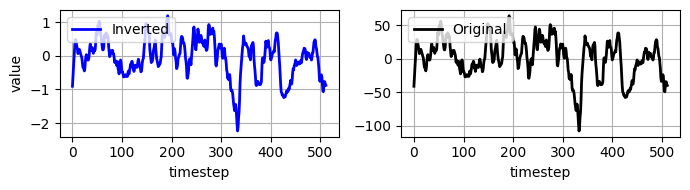

In [4]:
import matplotlib.pyplot as plt

# Get the data
example_idx = 1000
inverted_data = inverter(dataset[example_idx]['data'].unsqueeze(0)).detach().cpu().float().numpy().flatten()
original_data = dataset[example_idx]['data'].unsqueeze(0).detach().cpu().float().numpy().flatten()

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2))

# Plot inverted data on first axis
ax1.plot(inverted_data, color='blue', linewidth=2, label='Inverted')
ax1.set_xlabel('timestep')
ax1.set_ylabel('value') 
ax1.grid(True)
ax1.legend(loc='upper left')

# Plot original data on second axis
ax2.plot(original_data, color='k', linewidth=2, label='Original')
ax2.set_xlabel('timestep')
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Masker

In [5]:
class Masker(BFModule):
    def __init__(self, n_masked_intervals, interval_length):
        super().__init__()
        self.n_masked_intervals = n_masked_intervals
        self.interval_length = interval_length
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, channels)
        batch_size, seq_len, channels = x.shape
        
        # Initialize mask tensor with all True values
        mask = torch.ones_like(x, dtype=torch.bool)
        
        # For each sequence in the batch
        for b in range(batch_size):
            # Get n_masked_intervals random start positions
            # Make sure intervals don't go beyond sequence length
            max_start = seq_len - self.interval_length
            starts = torch.randint(0, max_start + 1, (self.n_masked_intervals,))
            
            # Create masks for each interval
            for start in starts:
                end = start + self.interval_length
                mask[b, start:end] = False
        
        # Apply mask to input
        masked_x = x * mask
        
        return masked_x, mask


### Embedder

In [6]:
class Embedder(BFModule):
    def __init__(self, d_model, resolution=10, range=(-3, 3)):
        super().__init__()
        self.d_model = d_model
        self.resolution = resolution
        self.range = range
        self.delta = (range[1] - range[0]) / (resolution-1)

        self.embedding_centers = torch.linspace(range[0], range[1], resolution)
        self.embedding_weights = torch.nn.Parameter(torch.randn(resolution, d_model) / d_model)
        
    def forward(self, x):
        # x is of shape (batch_size, seq_len, n_channels)
        # output is of shape (batch_size, seq_len, n_channels, d_model)
        output = torch.zeros(*x.shape, self.d_model, device=x.device, dtype=x.dtype)
        for center_i, embedding_center in enumerate(self.embedding_centers):
            distance_multiplier = torch.maximum(1 - torch.abs(x - embedding_center) / self.delta, torch.tensor(0))
            output += distance_multiplier.unsqueeze(-1) * self.embedding_weights[center_i].view(1, 1, 1, -1)
        output[x<self.range[0]] = self.embedding_weights[0]
        output[x>self.range[1]] = self.embedding_weights[-1]
        return output

In [7]:
class Model(BFModule):
    def __init__():
        pass

    def generate_continuation(self, batch, n_steps, vocab):
        """
        Generate a continuation of the input sequence for n_steps steps.
        
        Args:
            batch: Input sequence of shape (batch_size, seq_len, 1)
            n_steps: Number of steps to generate
            vocab: Tensor of possible samples to choose from, shape (n_samples, d_model)
        
        Returns:
            Tensor of shape (batch_size, seq_len + n_steps, 1) containing the original sequence
            concatenated with the generated continuation
        """
        # Start with the input batch
        current_sequence = batch.clone()
        # Generate n_steps new timesteps
        for _ in range(n_steps):
            # Get next step prediction
            next_values = self.generate_next_step(current_sequence, vocab).unsqueeze(1)
            # Concatenate with current sequence
            current_sequence = torch.cat([current_sequence, next_values], dim=1)
        return current_sequence
    
class ContrastiveModel(Model):
    def __init__(self, d_model=128, n_layers=4, n_heads=8, d_input=1):
        super(Model, self).__init__()
        self.d_input = d_input
        self.d_model = d_model
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.transformer = Transformer(d_input=d_model, d_model=d_model, d_output=d_model, 
                                        n_layer=n_layers, n_head=n_heads, causal=True, 
                                        rope=True, cls_token=False, rope_base=window_size*2 // d_input)
        self.embed = Embedder(d_model=d_model, resolution=2, range=(-3, 3))
        self.unembed = Embedder(d_model=d_model, resolution=2, range=(-3, 3))
    
    def forward(self, x, y=None):
        # x is of shape (batch_size, seq_len, d_input)
        # y is of shape (batch_size, seq_len, d_input)
        x = self.embed(x).squeeze(-2) # shape (batch_size, seq_len, d_model)
        x = self.transformer(x) # shape (batch_size, seq_len, d_model)

        if y is not None:
            y = self.unembed(y).squeeze(-2) # shape (batch_size, seq_len, d_model)
            return x, y
        return x
        
    def calculate_loss(self, batch):
        # batch is of shape (batch_size, seq_len, d_input)
        x, y = self(batch[:, :-1], batch[:, 1:])
        batch_size = batch.shape[0]

        similarity = torch.matmul(x[:, :].permute(1, 0, 2), y[:, :].permute(1, 2, 0))
        expanded_arange = torch.arange(batch_size).unsqueeze(0).repeat(x.shape[1], 1).to(device, dtype=torch.long).reshape(-1)
        loss = torch.nn.functional.cross_entropy(similarity.view(-1, batch_size), expanded_arange)
        return loss

In [8]:
n_steps = 2000
batch_size = 128
import itertools
dataloader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True))
dataloader = iter(itertools.cycle(dataloader))

n_samples_per_bin = 1
model = ContrastiveModel(d_input=n_samples_per_bin).to(device, dtype=dtype)
inverter = DistributionInverter(samples=samples).to(device, dtype=dtype)

## 3. Evaluation class

In [9]:
import sklearn
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from btbench.btbench_train_test_splits import generate_splits_SS_SM
import numpy as np

class ModelEvaluation_BTBench():
    def __init__(self, model, inverter, subject_trials, eval_names, batch_size=128, dtype=torch.float32, feature_aggregation_method='mean', mean_collapse_factor=1):
        self.model = model
        self.inverter = inverter
        self.subject_trials = subject_trials
        self.eval_names = eval_names
        self.batch_size = batch_size
        self.dtype = dtype
        self.feature_aggregation_method = feature_aggregation_method
        self.mean_collapse_factor = mean_collapse_factor
        
        # Create evaluation datasets
        self.evaluation_datasets = {}
        for eval_name in self.eval_names:
            for subject, trial_id in self.subject_trials:
                splits = generate_splits_SS_SM(subject, trial_id, eval_name, dtype=self.dtype,
                                               start_neural_data_before_word_onset=0,
                                               end_neural_data_after_word_onset=2048)
                self.evaluation_datasets[(eval_name, subject.subject_identifier, trial_id)] = splits

    def evaluate_on_dataset(self, train_dataset, test_dataset):
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)
        test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)
        
        device = next(self.model.parameters()).device
        
        # Get embeddings for train and test data
        X_train, y_train = [], []
        for batch_input, batch_label in train_dataloader:
            batch_input = batch_input.to(device, dtype=self.dtype)
            window_size = batch_input.shape[2]
            batch_data = batch_input.to(device, dtype=dtype).reshape(self.batch_size, window_size//n_samples_per_bin, n_samples_per_bin) # shape (batch_size, seq_len, 1)
            batch_data = self.inverter(batch_data)

            with torch.no_grad():
                x_embed = self.model(batch_data)
            
            batch_size, seq_len, d_model = x_embed.shape
            x_embed = x_embed.reshape(self.batch_size, seq_len//self.mean_collapse_factor, self.mean_collapse_factor, d_model)
            x_embed = x_embed.mean(dim=2)

            if self.feature_aggregation_method == 'mean':
                X_train.append(x_embed.mean(dim=1).cpu().float().numpy())  # Average across sequence length
            elif self.feature_aggregation_method == 'concat':
                X_train.append(x_embed.reshape(self.batch_size, -1).cpu().float().numpy())  # Concatenate across sequence length
            y_train.append(batch_label.numpy())        
        X_test, y_test = [], []
        for batch_input, batch_label in test_dataloader:
            batch_input = batch_input.to(device, dtype=self.dtype)
            batch_data = batch_input.to(device, dtype=dtype).reshape(self.batch_size, window_size//n_samples_per_bin, n_samples_per_bin) # shape (batch_size, seq_len, 1)
            batch_data = self.inverter(batch_data)

            with torch.no_grad():
                x_embed = self.model(batch_data)
            batch_size, seq_len, d_model = x_embed.shape
            x_embed = x_embed.reshape(self.batch_size, seq_len//self.mean_collapse_factor, self.mean_collapse_factor, d_model)
            x_embed = x_embed.mean(dim=2)

            if self.feature_aggregation_method == 'mean':
                X_test.append(x_embed.mean(dim=1).cpu().float().numpy())
            elif self.feature_aggregation_method == 'concat':
                X_test.append(x_embed.reshape(self.batch_size, -1).cpu().float().numpy())
            y_test.append(batch_label.numpy())

        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train)
        X_test = np.concatenate(X_test)
        y_test = np.concatenate(y_test)

        # Train logistic regression classifier
        clf = LogisticRegression(random_state=42, max_iter=10000)
        clf.fit(X_train, y_train)

        # Get predictions and calculate metrics
        test_probs = clf.predict_proba(X_test)
        accuracy = clf.score(X_test, y_test)
        
        # Calculate AUROC
        y_test_onehot = np.zeros((len(y_test), len(clf.classes_)))
        for i, label in enumerate(y_test):
            class_idx = np.where(clf.classes_ == label)[0][0]
            y_test_onehot[i, class_idx] = 1
            
        if len(clf.classes_) > 2:
            auroc = sklearn.metrics.roc_auc_score(y_test_onehot, test_probs, multi_class='ovr', average='macro')
        else:
            auroc = sklearn.metrics.roc_auc_score(y_test_onehot, test_probs)
            
        return auroc, accuracy

    def evaluate(self):
        results = {}
        for subject in set(subject for subject, _ in self.subject_trials):
            for eval_name in self.eval_names:
                trial_ids = [trial_id for _subject, trial_id in self.subject_trials if _subject == subject]
                for trial_id in trial_ids:
                    splits = self.evaluation_datasets[(eval_name, subject.subject_identifier, trial_id)]
                    auroc_list, acc_list = [], []
                    for train_dataset, test_dataset in zip(splits[0], splits[1]):
                        auroc, acc = self.evaluate_on_dataset(train_dataset, test_dataset)
                        auroc_list.append(auroc)
                        acc_list.append(acc)
                    
                    mean_auroc = np.mean(auroc_list)
                    mean_acc = np.mean(acc_list)
                    results[(eval_name, subject.subject_identifier, trial_id)] = (mean_auroc, mean_acc)
                    
        return self._format_results(results)
        
    def _format_results(self, results):
        formatted_results = {}
        for eval_name in self.eval_names:
            auroc_values = []
            acc_values = []
            subject_aurocs = {}
            subject_accs = {}
            
            for (metric, subject_id, trial_id) in [k for k in results.keys() if k[0] == eval_name]:
                if subject_id not in subject_aurocs:
                    subject_aurocs[subject_id] = []
                    subject_accs[subject_id] = []
                    
                auroc, acc = results[(eval_name, subject_id, trial_id)]
                subject_aurocs[subject_id].append(auroc)
                subject_accs[subject_id].append(acc)
                
                formatted_results[f"eval_auroc/{subject_id}_{trial_id}_{eval_name}"] = auroc
                formatted_results[f"eval_acc/{subject_id}_{trial_id}_{eval_name}"] = acc
                
            for subject_id in subject_aurocs:
                auroc_values.append(np.mean(subject_aurocs[subject_id]))
                acc_values.append(np.mean(subject_accs[subject_id]))
                
            if auroc_values:
                formatted_results[f"eval_auroc/average_{eval_name}"] = np.mean(auroc_values)
                formatted_results[f"eval_acc/average_{eval_name}"] = np.mean(acc_values)
                
        return formatted_results


import ajilebench.ajilebench_train_test_splits
class ModelEvaluation_AjileBench():
    def __init__(self, model, inverter, subject_trials, eval_names, batch_size=128, dtype=torch.float32, feature_aggregation_method='mean', mean_collapse_factor=1):
        self.model = model
        self.inverter = inverter
        self.subject_trials = subject_trials
        self.eval_names = eval_names
        self.batch_size = batch_size
        self.dtype = dtype
        self.feature_aggregation_method = feature_aggregation_method
        self.mean_collapse_factor = mean_collapse_factor
        
        # Create evaluation datasets
        self.evaluation_datasets = {}
        for eval_name in self.eval_names:
            for subject, trial_id in self.subject_trials:
                splits = ajilebench.ajilebench_train_test_splits.generate_splits_SS_SM(subject, trial_id, eval_name, dtype=self.dtype,
                                                                                        start_neural_data_before_reach_onset=0,
                                                                                        end_neural_data_after_reach_onset=512)
                self.evaluation_datasets[(eval_name, subject.subject_identifier, trial_id)] = splits

    def evaluate_on_dataset(self, train_dataset, test_dataset):
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        
        device = next(self.model.parameters()).device
        
        # Get embeddings for train and test data
        X_train, y_train = [], []
        for batch_input, batch_label in train_dataloader:
            batch_input = batch_input.to(device, dtype=self.dtype)
            batch_size = batch_input.shape[0]
            window_size = batch_input.shape[2]
            batch_data = batch_input.to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, n_samples_per_bin) # shape (batch_size, seq_len, 1)
            batch_data = self.inverter(batch_data)

            with torch.no_grad():
                x_embed = self.model(batch_data)
            
            batch_size, seq_len, d_model = x_embed.shape
            x_embed = x_embed.reshape(batch_size, seq_len//self.mean_collapse_factor, self.mean_collapse_factor, d_model)
            x_embed = x_embed.mean(dim=2)

            if self.feature_aggregation_method == 'mean':
                X_train.append(x_embed.mean(dim=1).cpu().float().numpy())  # Average across sequence length
            elif self.feature_aggregation_method == 'concat':
                X_train.append(x_embed.reshape(batch_size, -1).cpu().float().numpy())  # Concatenate across sequence length
            y_train.append(batch_label.numpy())        
        X_test, y_test = [], []
        for batch_input, batch_label in test_dataloader:
            batch_input = batch_input.to(device, dtype=self.dtype)
            batch_size = batch_input.shape[0]
            window_size = batch_input.shape[2]
            batch_data = batch_input.to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, n_samples_per_bin) # shape (batch_size, seq_len, 1)
            batch_data = self.inverter(batch_data)

            with torch.no_grad():
                x_embed = self.model(batch_data)
            batch_size, seq_len, d_model = x_embed.shape
            x_embed = x_embed.reshape(batch_size, seq_len//self.mean_collapse_factor, self.mean_collapse_factor, d_model)
            x_embed = x_embed.mean(dim=2)

            if self.feature_aggregation_method == 'mean':
                X_test.append(x_embed.mean(dim=1).cpu().float().numpy())
            elif self.feature_aggregation_method == 'concat':
                X_test.append(x_embed.reshape(batch_size, -1).cpu().float().numpy())
            y_test.append(batch_label.numpy())

        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train)
        X_test = np.concatenate(X_test)
        y_test = np.concatenate(y_test)

        # Train logistic regression classifier
        clf = LogisticRegression(random_state=42, max_iter=10000)
        clf.fit(X_train, y_train)

        # Get predictions and calculate metrics
        test_probs = clf.predict_proba(X_test)
        accuracy = clf.score(X_test, y_test)
        
        # Calculate AUROC
        y_test_onehot = np.zeros((len(y_test), len(clf.classes_)))
        for i, label in enumerate(y_test):
            class_idx = np.where(clf.classes_ == label)[0][0]
            y_test_onehot[i, class_idx] = 1
            
        if len(clf.classes_) > 2:
            auroc = sklearn.metrics.roc_auc_score(y_test_onehot, test_probs, multi_class='ovr', average='macro')
        else:
            auroc = sklearn.metrics.roc_auc_score(y_test_onehot, test_probs)
            
        return auroc, accuracy

    def evaluate(self):
        results = {}
        for subject in set(subject for subject, _ in self.subject_trials):
            for eval_name in self.eval_names:
                trial_ids = [trial_id for _subject, trial_id in self.subject_trials if _subject == subject]
                for trial_id in trial_ids:
                    splits = self.evaluation_datasets[(eval_name, subject.subject_identifier, trial_id)]
                    auroc_list, acc_list = [], []
                    for train_dataset, test_dataset in zip(splits[0], splits[1]):
                        auroc, acc = self.evaluate_on_dataset(train_dataset, test_dataset)
                        auroc_list.append(auroc)
                        acc_list.append(acc)
                    
                    mean_auroc = np.mean(auroc_list)
                    mean_acc = np.mean(acc_list)
                    results[(eval_name, subject.subject_identifier, trial_id)] = (mean_auroc, mean_acc)
                    
        return self._format_results(results)
        
    def _format_results(self, results):
        formatted_results = {}
        for eval_name in self.eval_names:
            auroc_values = []
            acc_values = []
            subject_aurocs = {}
            subject_accs = {}
            
            for (metric, subject_id, trial_id) in [k for k in results.keys() if k[0] == eval_name]:
                if subject_id not in subject_aurocs:
                    subject_aurocs[subject_id] = []
                    subject_accs[subject_id] = []
                    
                auroc, acc = results[(eval_name, subject_id, trial_id)]
                subject_aurocs[subject_id].append(auroc)
                subject_accs[subject_id].append(acc)
                
                formatted_results[f"eval_auroc/{subject_id}_{trial_id}_{eval_name}"] = auroc
                formatted_results[f"eval_acc/{subject_id}_{trial_id}_{eval_name}"] = acc
                
            for subject_id in subject_aurocs:
                auroc_values.append(np.mean(subject_aurocs[subject_id]))
                acc_values.append(np.mean(subject_accs[subject_id]))
                
            if auroc_values:
                formatted_results[f"eval_auroc/average_{eval_name}"] = np.mean(auroc_values)
                formatted_results[f"eval_acc/average_{eval_name}"] = np.mean(acc_values)
                
        return formatted_results

In [16]:
evaluation = ModelEvaluation_AjileBench(model, inverter, [(subject, trial_id)], ["reach_onset"], feature_aggregation_method='concat', mean_collapse_factor=1)
evaluation.evaluate()

{'eval_auroc/ajile3_4_reach_onset': 0.5198531390565531,
 'eval_acc/ajile3_4_reach_onset': 0.5268108108108108,
 'eval_auroc/average_reach_onset': 0.5198531390565531,
 'eval_acc/average_reach_onset': 0.5268108108108108}

## 4. Training the model

In [11]:
initial_lr = 0.003
use_muon = True
optimizers = []
schedulers = []
if use_muon:
    from muon import Muon
    all_params = list(model.parameters())
    matrix_params = [p for p in all_params if p.ndim >= 2]
    other_params = [p for p in all_params if p.ndim < 2]
    optimizers.append(Muon(matrix_params, lr=initial_lr, momentum=0.95, nesterov=True, backend='newtonschulz5', backend_steps=5))
    if len(other_params) > 0:
        optimizers.append(torch.optim.AdamW(other_params, lr=initial_lr, betas=(0.9, 0.95)))
    #schedulers.append(None)  # Muon doesn't support schedulers
    #schedulers.append(torch.optim.lr_scheduler.LinearLR(optimizers[1], start_factor=1.0, end_factor=0.0, total_iters=n_steps))
else:
    optimizers = [torch.optim.AdamW(model.parameters(), lr=initial_lr, betas=(0.9, 0.95))]
    #schedulers = [torch.optim.lr_scheduler.LinearLR(optimizers[0], start_factor=1.0, end_factor=0.0, total_iters=n_steps)]

training_logs = []
step = 1
for batch in dataloader:
    for optimizer in optimizers:
        optimizer.zero_grad()

    batch_data = batch['data'].to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, n_samples_per_bin) # shape (batch_size, seq_len, 1)
    batch_data = inverter(batch_data)

    loss = model.calculate_loss(batch_data)
    loss.backward()
    for optimizer in optimizers:
        optimizer.step()
    
    # Step the schedulers
    for scheduler in schedulers:
        if scheduler is not None:
            scheduler.step()
    
    # Log metrics
    log_dict = {
        'train_loss': loss.item(),
        'unembed_std': model.embed.embedding_weights.data.cpu().float().numpy().std()
    }
    
    if step % 100 == 0:
        current_lr = optimizers[-1].param_groups[0]['lr']
        print(f"Step {step}, Loss: {loss.item():.4f}, LR: {current_lr:.6f}")
        print("\t std of embedding weights: ", log_dict['unembed_std'])
        
        # Add evaluation results
        evaluation_results = evaluation.evaluate()
        log_dict.update(evaluation_results)
        print(log_dict)
        
    training_logs.append(log_dict)
        
    if step == n_steps:
        break # Only process one batch per step
    step += 1


Step 100, Loss: 4.8438, LR: 0.003000
	 std of embedding weights:  0.023887008
{'train_loss': 4.84375, 'unembed_std': 0.023887008, 'eval_auroc/ajile3_4_reach_onset': 0.5531044558071585, 'eval_acc/ajile3_4_reach_onset': 0.5427387387387388, 'eval_auroc/average_reach_onset': 0.5531044558071585, 'eval_acc/average_reach_onset': 0.5427387387387388}
Step 200, Loss: 4.7500, LR: 0.003000
	 std of embedding weights:  0.036666617
{'train_loss': 4.75, 'unembed_std': 0.036666617, 'eval_auroc/ajile3_4_reach_onset': 0.5303948329552881, 'eval_acc/ajile3_4_reach_onset': 0.5104864864864865, 'eval_auroc/average_reach_onset': 0.5303948329552881, 'eval_acc/average_reach_onset': 0.5104864864864865}
Step 300, Loss: 4.5312, LR: 0.003000
	 std of embedding weights:  0.051168963
{'train_loss': 4.53125, 'unembed_std': 0.051168963, 'eval_auroc/ajile3_4_reach_onset': 0.5372842259044252, 'eval_acc/ajile3_4_reach_onset': 0.49985585585585585, 'eval_auroc/average_reach_onset': 0.5372842259044252, 'eval_acc/average_reac

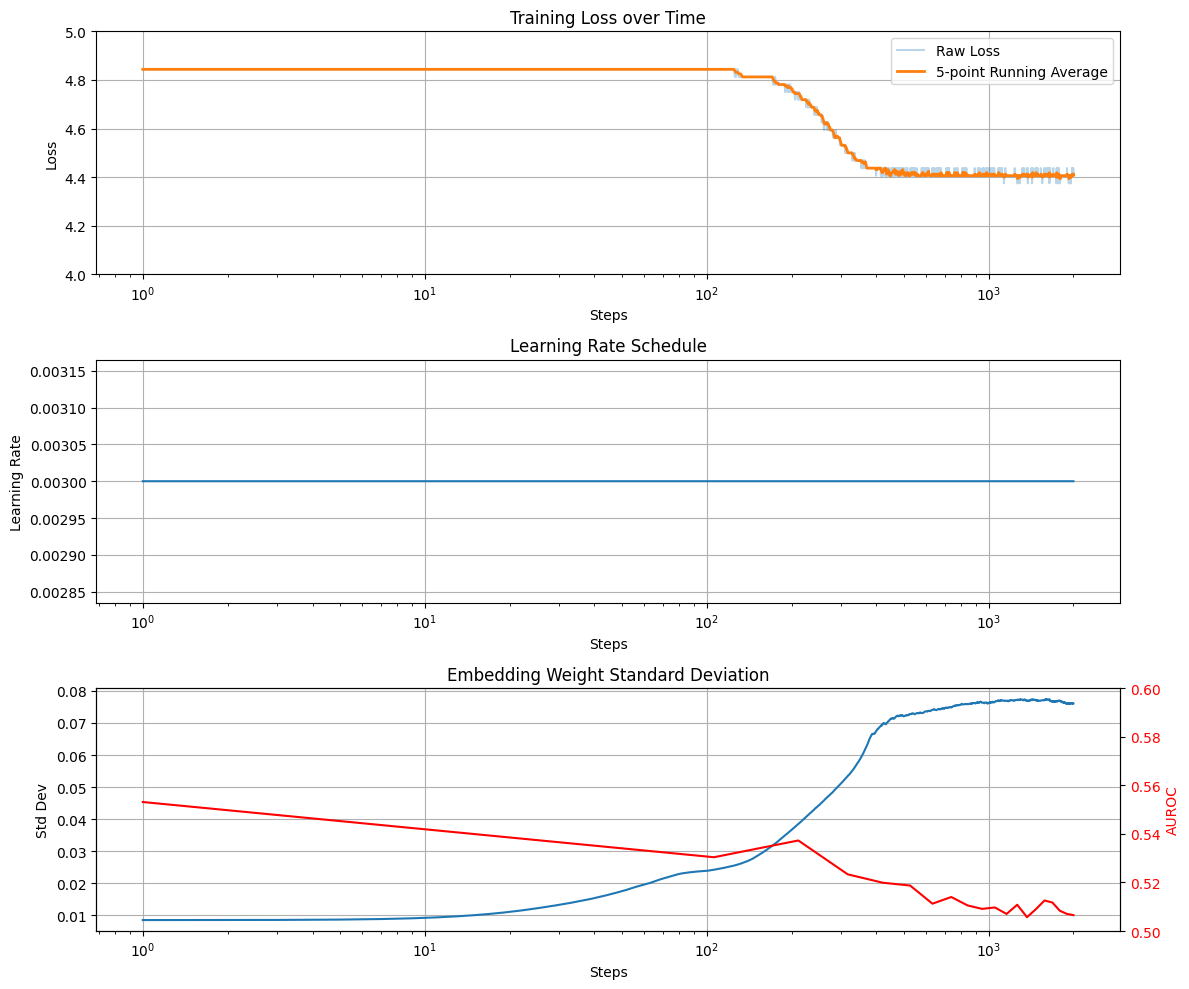

In [15]:
# Extract values from training logs
steps = []
losses = []
lrs = []
stds = []
aurocs = []
accs = []

# Parse the training logs list of dicts
step = 1
for log_dict in training_logs:
    steps.append(step)
    losses.append(log_dict['train_loss'])
    stds.append(log_dict['unembed_std'])
    
    # Extract evaluation metrics if available
    if 'eval_auroc/average_reach_onset' in log_dict:
        aurocs.append(log_dict['eval_auroc/average_reach_onset'])
        accs.append(log_dict['eval_acc/average_reach_onset'])
    
    # Get learning rate from last optimizer
    current_lr = optimizers[-1].param_groups[0]['lr']
    lrs.append(current_lr)
    step += 1

# Calculate running average of losses
n_ave = 5
running_avg_losses = []
for i in range(len(losses)):
    if i < n_ave - 1:
        # For first n_ave-1 points, average what we have
        running_avg_losses.append(sum(losses[:i+1]) / (i+1))
    else:
        # For remaining points, take n_ave point average
        running_avg_losses.append(sum(losses[i-n_ave+1:i+1]) / n_ave)

# Create figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Plot loss with running average
ax1.semilogx(steps, losses, alpha=0.3, label='Raw Loss')
ax1.semilogx(steps, running_avg_losses, linewidth=2, label=f'{n_ave}-point Running Average')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss over Time')
ax1.grid(True)
ax1.set_ylim(4.0, 5.0)
ax1.legend()

# Plot learning rate
ax2.semilogx(steps, lrs)
ax2.set_xlabel('Steps') 
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate Schedule')
ax2.grid(True)

# Plot embedding weight std
ax3.semilogx(steps, stds)
ax3.set_xlabel('Steps')
ax3.set_ylabel('Std Dev')
ax3.set_title('Embedding Weight Standard Deviation')
ax3.grid(True)

# If we have evaluation metrics, add them to the plot
if aurocs:
    # Create a twin axis for the AUROC values
    ax4 = ax3.twinx()
    eval_steps = np.linspace(1, len(steps), len(aurocs))  # Only use steps where we have eval metrics
    ax4.semilogx(eval_steps, aurocs, 'r-', label='AUROC')
    ax4.set_ylabel('AUROC', color='r')
    ax4.tick_params(axis='y', labelcolor='r')
    ax4.set_ylim(0.5, 0.6)  # Adjust based on your data

plt.tight_layout()
plt.show()


In [112]:
import random

vocab_size = 10000
vocab = []
for i in range(vocab_size // (window_size // n_samples_per_bin)):
    vocab.append(dataset[random.randint(0, len(dataset)-1)]['data'].reshape(window_size//n_samples_per_bin, n_samples_per_bin))
    vocab[-1] /= 100
vocab = torch.cat(vocab, dim=0)
vocab = vocab.to(device)
vocab_size = len(vocab)
print(vocab.shape)

torch.Size([9920, 4])


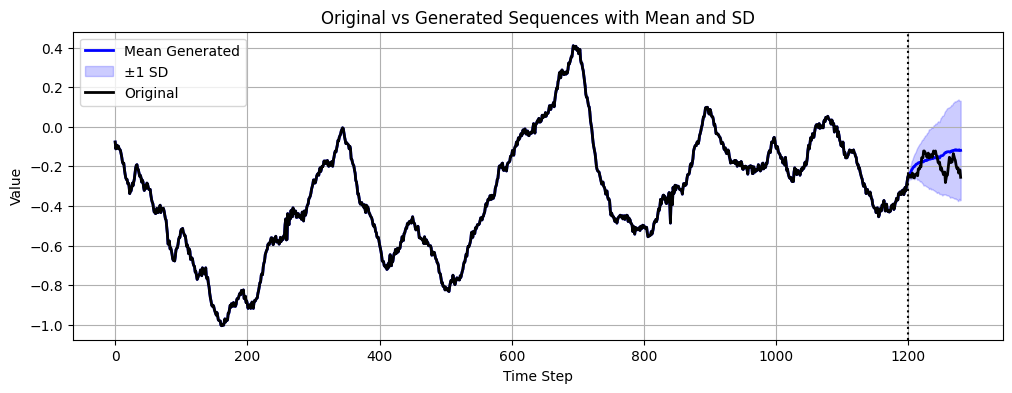

In [116]:
generate_steps = 20
n_generations = 100
batch_index = random.randint(0, len(dataset)-1)

example_seq = dataset[batch_index]['data'].reshape(window_size//n_samples_per_bin, n_samples_per_bin).unsqueeze(0).to(device)
example_seq = example_seq.expand(n_generations, -1, -1)
example_seq = example_seq / 100
continued_seq = model.generate_continuation(example_seq[:, :example_seq.shape[1]-generate_steps], generate_steps, vocab)

example_seq = example_seq[0,:].detach().cpu().numpy().flatten()

import matplotlib.pyplot as plt
import numpy as np

# Plot original and continued sequences
plt.figure(figsize=(12,4))

# Convert continued sequences to numpy array for statistics
continued_seqs_np = np.array([seq.detach().cpu().numpy().flatten() for seq in continued_seq])
mean_seq = np.mean(continued_seqs_np, axis=0)
std_seq = np.std(continued_seqs_np, axis=0)

# Plot individual continued sequences
# for i in range(n_generations):
#     continued_seq_item = continued_seqs_np[i]
#     plt.plot(continued_seq_item, '--', label='Generated' if i == 0 else None, alpha=0.2, color='red', linewidth=1)

# Plot mean and standard deviation
plt.plot(mean_seq, '-', color='blue', label='Mean Generated', linewidth=2)
plt.fill_between(range(len(mean_seq)), mean_seq-std_seq, mean_seq+std_seq, color='blue', alpha=0.2, label='±1 SD')
    
# Plot original sequence
plt.plot(example_seq, label='Original', alpha=1.0, color='k', linewidth=2)

# Add vertical line where generation starts
plt.axvline(x=example_seq.shape[0]-generate_steps*n_samples_per_bin, color='k', linestyle=':')

plt.legend()
plt.title('Original vs Generated Sequences with Mean and SD')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()
